In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score,GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from sklearn import metrics
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder, KBinsDiscretizer
from sklearn.metrics import confusion_matrix

In [2]:
train_df = pd.read_csv("/home/ubuntu/try/file/preprocessed_train.csv")
test_df = pd.read_csv("/home/ubuntu/try/file/preprocessed_test.csv")
id_column = pd.read_csv('/home/ubuntu/try/file/train_predicted_missingvalues.csv')['id']

# 열 리스트(범주, 순서, 수치)
categorical_cols = ['Occupation','TypeofContact', 'Gender', 'Marital_Status']
ordinal_cols = ['ProductPitched', 'Designation']
numerical_cols = ['Age', 'CityTier', 'DurationOfPitch', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'MonthlyIncome', 'Car_Ownership', 'Has_Children']

#순서형 변수 'Product Pitched' 와 'Designation'의 변수 순서
orders = [['basic','standard','deluxe','super deluxe','king'],
          ['vp','avp','executive','manager','senior manager']]

결측치처리

In [3]:
# 결측치 처리
# 수치형 - KNN Imputer
numerical_imputer = KNNImputer()
train_df[numerical_cols] = numerical_imputer.fit_transform(train_df[numerical_cols])
test_df[numerical_cols] = numerical_imputer.transform(test_df[numerical_cols])

# 범주, 순서형 - 최빈, 결측값은 근데 TypeOfContact에 6, 12개밖에 없음
# 범주형 - Simple Imputer
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_df[categorical_cols + ordinal_cols] = categorical_imputer.fit_transform(train_df[categorical_cols + ordinal_cols])
test_df[categorical_cols + ordinal_cols] = categorical_imputer.transform(test_df[categorical_cols + ordinal_cols])

In [4]:
# NumberOfFollowups 이상치 처리
#이상치 처리 클리핑 - 4보다 크면 4로 변경
train_df['NumberOfFollowups'] = train_df['NumberOfFollowups'].apply(lambda x: min(x, 4))
test_df['NumberOfFollowups'] = test_df['NumberOfFollowups'].apply(lambda x: min(x, 4))

# # NumberOfFollowups 이상치 처리 - 새로운 변수로 처리(1)
# # (75%)3분위수 값인 4보다 크면 1, 작으면 0
# X['NumberOfFollowups_outlier'] = X['NumberOfFollowups'].apply(lambda x: 1 if x > 4 else 0)
# test_df['NumberOfFollowups_outlier'] = test_df['NumberOfFollowups'].apply(lambda x: 1 if x > 4 else 0)

#MonthlyIncome 변수를 범주화 (KBinsDiscretizer)
kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
train_df['Income_Category'] = kbins.fit_transform(train_df[['MonthlyIncome']])
test_df['Income_Category'] = kbins.transform(test_df[['MonthlyIncome']])

인코딩

In [5]:
# 순서형 열과 범주형 열에 대해 Label Encoding, Ordinal Encoding 적용
for id, col in enumerate(ordinal_cols):
    oe = OrdinalEncoder(categories=[orders[id]])
    train_df[col] = oe.fit_transform(train_df[[col]].astype(str))
    test_df[col] = oe.fit_transform(test_df[[col]].astype(str))

for id, col in enumerate(categorical_cols):
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    test_df[col] = le.fit_transform(test_df[col].astype(str))

예측모델 함수 생성

In [6]:
target = 'ProdTaken'
IDcol = 'id'

train_df['id']=id_column

하이퍼파라미터 튜닝 depth,weight


Model Report
AUC: 0.8895


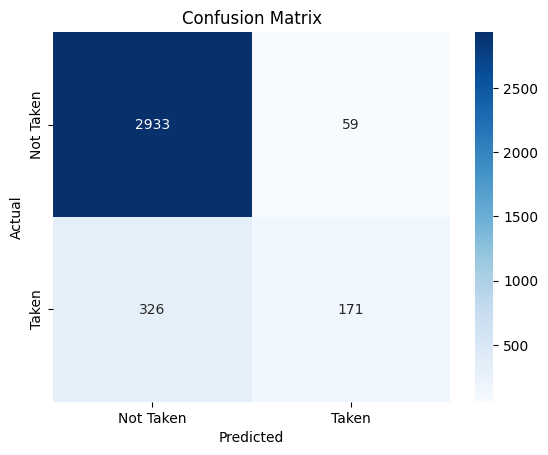

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2992
           1       0.74      0.34      0.47       497

    accuracy                           0.89      3489
   macro avg       0.82      0.66      0.70      3489
weighted avg       0.88      0.89      0.87      3489



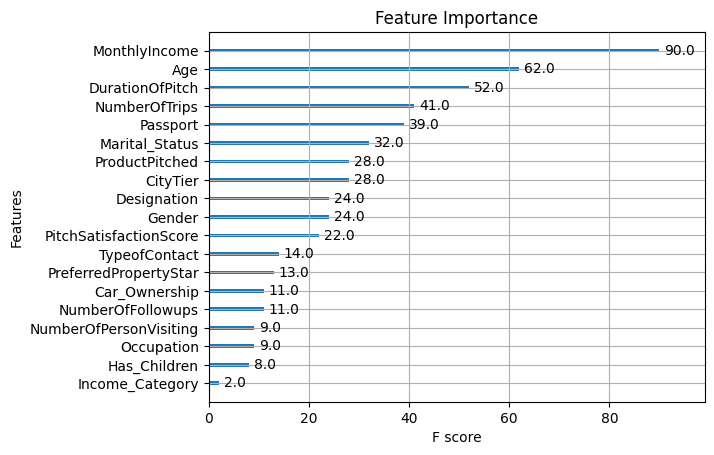

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['ProdTaken'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                           metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['ProdTaken'])
    
    # Predict training set
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:, 1]
    
    # Print model report
    print("\nModel Report")
    print("AUC: %.4g" % metrics.roc_auc_score(dtrain['ProdTaken'].values, dtrain_predprob))
    
    
    # Confusion Matrix
    cm = confusion_matrix(dtrain['ProdTaken'], dtrain_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Taken', 'Taken'], yticklabels=['Not Taken', 'Taken'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Classification Report
    print(classification_report(dtrain['ProdTaken'], dtrain_predictions))
    
    # Feature Importance
    xgb.plot_importance(alg)
    plt.title('Feature Importance')
    plt.show()

# Predictors 설정
predictors = [x for x in train_df.columns if x not in ['ProdTaken', IDcol]]

# 모델 초기화
xgb1 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=3,
    min_child_weight=1,
    gamma=0.4,
    subsample=0.67,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)

# 모델 피팅
modelfit(xgb1, train_df, predictors)


In [8]:
train_df.head()

,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,...,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,Marital_Status,Car_Ownership,Has_Children,ProdTaken,Income_Category,id
0,50.0,1,2.0,900.0,0,1,1.0,4.0,0.0,3.0,...,1.0,4.0,2.0,253905.0,3,0.0,0.0,1,0.0,0
1,56.0,0,1.0,840.0,1,1,1.0,4.0,1.0,3.0,...,1.0,4.0,4.0,404475.0,0,1.0,0.0,0,3.0,1
2,36.0,1,1.0,600.0,0,0,1.0,3.0,0.0,3.0,...,0.0,4.0,2.0,278145.0,1,0.0,0.0,1,0.0,2
3,20.0,1,2.0,1080.0,2,0,1.0,3.0,1.0,4.0,...,0.0,5.0,4.0,326805.0,0,1.0,0.0,0,2.0,3
4,48.0,0,3.0,1020.0,2,0,1.0,3.0,0.0,4.0,...,0.0,4.0,2.0,258435.0,2,1.0,0.0,1,0.0,4
